<a href="https://colab.research.google.com/github/frankrefischer/tf-cnn-cats-and-dogs/blob/master/CNN_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from glob import glob

In [4]:
def download_cats_and_dogs_data():
  download_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
  filepath = tf.keras.utils.get_file('cats_and_dogs.zip', origin=download_url, extract=True)
  return Path(filepath).parent.joinpath('cats_and_dogs_filtered')

data_dir = download_cats_and_dogs_data()

In [5]:
data_dir

WindowsPath('C:/Users/fisch/.keras/datasets/cats_and_dogs_filtered')

In [6]:
glob(data_dir.joinpath('*/*').as_posix())

['C:/Users/fisch/.keras/datasets/cats_and_dogs_filtered\\train\\cats',
 'C:/Users/fisch/.keras/datasets/cats_and_dogs_filtered\\train\\dogs',
 'C:/Users/fisch/.keras/datasets/cats_and_dogs_filtered\\validation\\cats',
 'C:/Users/fisch/.keras/datasets/cats_and_dogs_filtered\\validation\\dogs']

In [7]:
train_dir = data_dir.joinpath('train')
validation_dir = data_dir.joinpath('validation')

In [8]:
train_cats_dir = train_dir.joinpath('cats')
train_dogs_dir = train_dir.joinpath('dogs')
validation_cats_dir = validation_dir.joinpath('cats')
validation_dogs_dir = validation_dir.joinpath('dogs')

In [39]:
def count_images(train, dogs=False, cats=False):
    total = 0
    cats_dir, dogs_dir = (train_cats_dir, train_dogs_dir) if train else (validation_cats_dir, validation_dogs_dir)
    
    if cats:
        total += len(list(cats_dir.glob('*')))
    if dogs:
        total += len(list(dogs_dir.glob('*')))

    return total

def how_many_cats_and_dogs_images_are_there():
  print(f'total training cat images:   {count_images(train=True, cats=True):4}')
  print(f'total training dog images:   {count_images(train=True, dogs=True):4}')
  print(f'total validation cat images: {count_images(train=False, cats=True):4}')
  print(f'total validation dog images:{count_images(train=False, cats=True):4}')

  print('--')

  print(f'Total training images:   {count_images(train=True, cats=True, dogs=True):4}')
  print(f'Total validation images: {count_images(train=False, cats=True, dogs=True):4}')

how_many_cats_and_dogs_images_are_there()

total training cat images:   1000
total training dog images:   1000
total validation cat images:  500
total validation dog images: 500
--
Total training images:   2000
Total validation images: 1000


In [10]:
def generate_images(img_dir, batch_size=128, epochs=15, img_size=(150, 150)):
  return ImageDataGenerator(rescale=1./255).flow_from_directory(batch_size=batch_size,
                                                                directory=img_dir,
                                                                shuffle=True,
                                                                target_size=img_size,
                                                                class_mode='binary')

In [11]:
train_data_gen = generate_images(img_dir=train_dir)

Found 2000 images belonging to 2 classes.


In [12]:
val_data_gen = generate_images(img_dir=validation_dir)

Found 1000 images belonging to 2 classes.


Found 2000 images belonging to 2 classes.


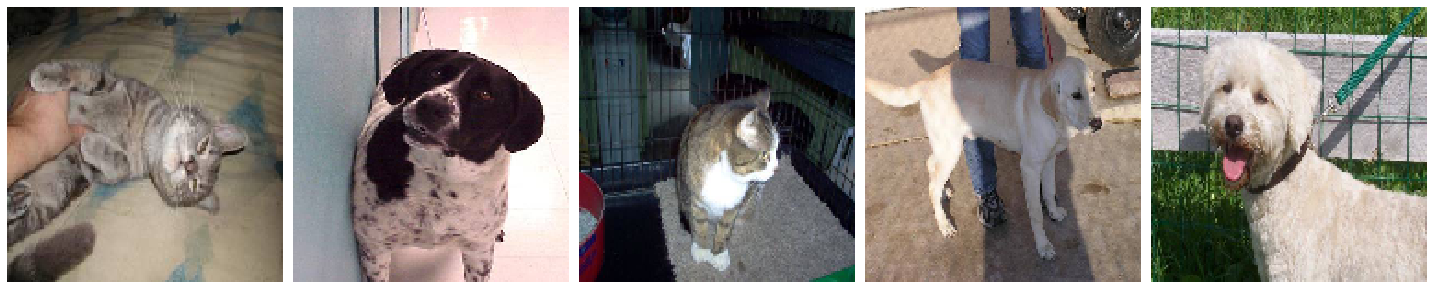

In [23]:
def plot_images(img_arr):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    
def visualize_images(img_dir):
    img_gen = generate_images(img_dir=img_dir)
    sample_images, _ = next(img_gen)
    plot_images(sample_images[:5])
    
visualize_images(train_dir)

In [26]:
def create_model(input_shape=(150, 150, 3)):
    return Sequential([
        Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [51]:
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 20736)            

In [53]:
def train_model(model, batch_size=128, epochs=15):
    history = model.fit_generator(generator=generate_images(train_dir),
                                  steps_per_epoch=count_images(train=True, cats=True, dogs=True) // batch_size,
                                  epochs=15,
                                  validation_data=generate_images(validation_dir),
                                  validation_steps=count_images(train=False, cats=True, dogs=True) // batch_size)
    return history

train_history = train_model(model)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15
15/15 [==============================] - 5s 363ms/step - loss: 0.8102 - accuracy: 0.5176 - val_loss: 0.6909 - val_accuracy: 0.5022
Epoch 2/15
15/15 [==============================] - 5s 349ms/step - loss: 0.6913 - accuracy: 0.5059 - val_loss: 0.6883 - val_accuracy: 0.5938
Epoch 3/15
15/15 [==============================] - 5s 342ms/step - loss: 0.6729 - accuracy: 0.6016 - val_loss: 0.7043 - val_accuracy: 0.5100
Epoch 4/15
15/15 [==============================] - 5s 334ms/step - loss: 0.6703 - accuracy: 0.5976 - val_loss: 0.6752 - val_accuracy: 0.6060
Epoch 5/15
15/15 [==============================] - 5s 330ms/step - loss: 0.5948 - accuracy: 0.6928 - val_loss: 0.6188 - val_accuracy: 0.6786
Epoch 6/15
15/15 [==============================] - 5s 317ms/step - loss: 0.5371 - accuracy: 0.7406 - val_loss: 0.6198 - val_accuracy: 0.6417
Epoch 7/15
15/15 [==============================] - 5s 301ms/ste

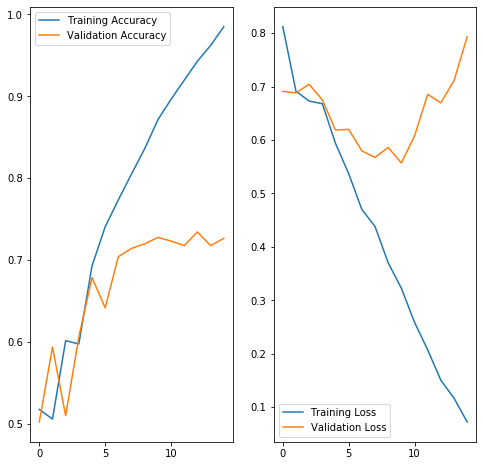

In [54]:
def visualize_training_history(history, epochs=15):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8,8))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), acc, label='Training Accuracy')
    plt.plot(range(epochs), val_acc, label='Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), loss, label='Training Loss')
    plt.plot(range(epochs), val_loss, label='Validation Loss')
    plt.legend()
    
    
visualize_training_history(train_history)